In [184]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV

Text(0.5, 1.0, 'Fengyun-2D - Brouwer Mean Motion')

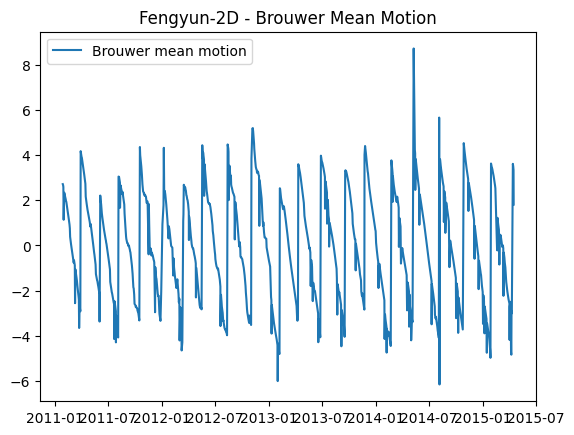

In [185]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Fengyun-2D.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Centering and scaling the data
df_bmm = (df_bmm - df_bmm.mean()) * 1e7

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("Fengyun-2D - Brouwer Mean Motion")

In [186]:
""" start_date = pd.to_datetime("2017")
end_date = pd.to_datetime("2021")

# Filtering maneuvers based on the date range
df_bmm = df_bmm[df_bmm.index >= start_date]
df_bmm = df_bmm[df_bmm.index <= end_date]

df_bmm """

' start_date = pd.to_datetime("2017")\nend_date = pd.to_datetime("2021")\n\n# Filtering maneuvers based on the date range\ndf_bmm = df_bmm[df_bmm.index >= start_date]\ndf_bmm = df_bmm[df_bmm.index <= end_date]\n\ndf_bmm '

In [187]:
NUM_LAG_FEATURES = 3

# Creating features and labels
df_bmm_y = df_bmm.copy()
df_bmm_x = df_bmm.shift(1)

# Renaming the 1st Lag feature
df_bmm_x = df_bmm_x.rename(columns={"Brouwer mean motion": "bmm_lag_1"})

# Adding the rest of the lag features based on the number of lags
for lag in range(2,NUM_LAG_FEATURES + 1):
    df_bmm_x[f"bmm_lag_{lag}"] = df_bmm.shift(lag)

In [188]:
df_bmm_x

,bmm_lag_1,bmm_lag_2,bmm_lag_3
2011-01-27 14:08:12.153119,NaN,NaN,NaN
2011-01-28 17:37:05.756160,2.718723,NaN,NaN
2011-01-29 15:15:38.467295,2.671173,2.718723,NaN
2011-01-30 15:10:21.948671,2.591334,2.671173,2.718723
2011-02-01 14:21:40.146048,1.138477,2.591334,2.671173
...,...,...,...
2015-04-10 01:46:29.584127,-2.897527,-4.841660,-4.728232
2015-04-13 13:46:11.083296,-3.007901,-2.897527,-4.841660
2015-04-14 20:58:23.309760,3.617698,-3.007901,-2.897527
2015-04-15 21:43:48.910080,3.505147,3.617698,-3.007901


In [189]:
df_bmm_y

,Brouwer mean motion
2011-01-27 14:08:12.153119,2.718723
2011-01-28 17:37:05.756160,2.671173
2011-01-29 15:15:38.467295,2.591334
2011-01-30 15:10:21.948671,1.138477
2011-02-01 14:21:40.146048,2.340041
...,...
2015-04-10 01:46:29.584127,-3.007901
2015-04-13 13:46:11.083296,3.617698
2015-04-14 20:58:23.309760,3.505147
2015-04-15 21:43:48.910080,3.347217


In [190]:
# Removing rows with NaN values
df_bmm_y = df_bmm_y.iloc[NUM_LAG_FEATURES:]
df_bmm_x = df_bmm_x.iloc[NUM_LAG_FEATURES:]

In [191]:
# Train Test data splitting based on date
SPLIT_DATE = "2014-06-05"
df_bmm_x_train = df_bmm_x[:SPLIT_DATE]
df_bmm_x_test = df_bmm_x[SPLIT_DATE:]
df_bmm_y_train = df_bmm_y[:SPLIT_DATE]
df_bmm_y_test = df_bmm_y[SPLIT_DATE:]

In [192]:
# Getting the training data percentage
train_percentage = df_bmm_y_train.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(train_percentage*100,2))

80.08


In [193]:
# Getting the testing data percentage
test_percentage = df_bmm_y_test.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(test_percentage*100,2))

19.92


In [194]:
# Using grid search to find the best hyperparameters
def grid_search_xgboost(X_train, y_train, cv = 5, verbose = 1):
    param_grid = {
        'n_estimators': [100,1000,1500,2000],
        'max_depth': [5,7,9],
        'learning_rate': [0.01,0.001,0.1],
        'colsample_bytree': [0.5,0.8,1],
        'min_child_weight': [3,5,7]
    }

    xgb_model = XGBRegressor(random_state = 25)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=verbose,
        n_jobs=1
    )

    grid_search.fit(X_train,y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters Found:")
    print(best_params)

    return best_model, best_params

best_xgb_model, best_xgb_params = grid_search_xgboost(df_bmm_x_train,df_bmm_y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters Found:
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 1000}


In [209]:
# Creating the XGBoost regressor with early stopping to avoid overfitting
xgb_regressor = XGBRegressor(
    n_estimators = 1000,
    max_depth = 5,
    learning_rate = 0.01,
    colsample_bytree = 1,
    min_child_weight = 3,
    subsample = 1,
    eval_metric = 'mae',
    early_stopping_rounds = 10
)

In [210]:
# Fitting the XGBoost model
xgb_regressor.fit(
    df_bmm_x_train,
    df_bmm_y_train,
    eval_set = [(df_bmm_x_train,df_bmm_y_train), (df_bmm_x_test,df_bmm_y_test)],
    verbose = True
)

[0]	validation_0-mae:1.94971	validation_1-mae:2.11659


[1]	validation_0-mae:1.93279	validation_1-mae:2.09991
[2]	validation_0-mae:1.91604	validation_1-mae:2.08330
[3]	validation_0-mae:1.89943	validation_1-mae:2.06699
[4]	validation_0-mae:1.88298	validation_1-mae:2.05070
[5]	validation_0-mae:1.86669	validation_1-mae:2.03463
[6]	validation_0-mae:1.85057	validation_1-mae:2.01865
[7]	validation_0-mae:1.83460	validation_1-mae:2.00298
[8]	validation_0-mae:1.81879	validation_1-mae:1.98728
[9]	validation_0-mae:1.80313	validation_1-mae:1.97193
[10]	validation_0-mae:1.78762	validation_1-mae:1.95659
[11]	validation_0-mae:1.77227	validation_1-mae:1.94145
[12]	validation_0-mae:1.75705	validation_1-mae:1.92643
[13]	validation_0-mae:1.74204	validation_1-mae:1.91164
[14]	validation_0-mae:1.72715	validation_1-mae:1.89689
[15]	validation_0-mae:1.71245	validation_1-mae:1.88227
[16]	validation_0-mae:1.69792	validation_1-mae:1.86804
[17]	validation_0-mae:1.68359	validation_1-mae:1.85388
[18]	validation_0-mae:1.66932	validation_1-mae:1.84000
[19]	validation_0-m

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=10, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

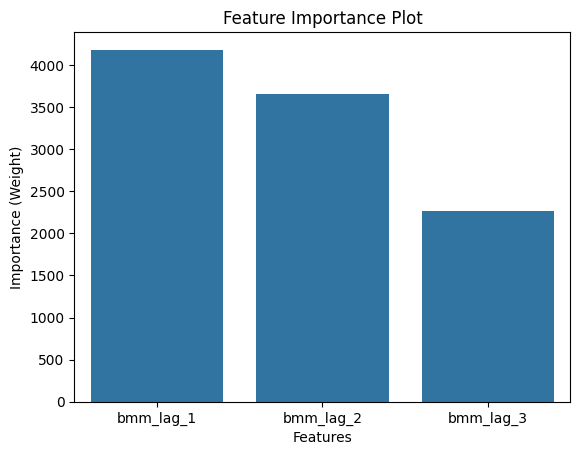

In [211]:
# Generating the feature importance plot
feature_importance = xgb_regressor.get_booster().get_score(importance_type = "weight")
sns.barplot(x = list(feature_importance.keys()), y = list(feature_importance.values()))
plt.xlabel("Features")
plt.ylabel("Importance (Weight)")
plt.title("Feature Importance Plot")
plt.show()

In [212]:
# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/manFY2D.txt.fy'

data = []

# Reading the file data into the list
with open(maneuver_file_path, 'r') as file:
    for line in file:
        # Splitting the line by space
        parts = line.strip().split('"')
        #maneuver_type, satellite_id = parts[0].strip().split()[:2]
        start_date = parts[1]
        #end_time = parts[3]
        data.append(start_date)

# Defining the column names
column_names = ['Start_Date']

# Creating a dataframe with the text file data
df = pd.DataFrame(data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])

# Checking the dataframe
print(df.head())

           Start_Date
0 2015-04-10 15:30:00
1 2015-01-27 14:30:00
2 2014-10-24 15:30:00
3 2014-08-04 15:30:00
4 2014-05-09 15:30:00


/var/folders/5m/f9w6_kb12kn6r38z9rjzgfk00000gn/T/ipykernel_1573/2644158969.py:23: FutureWarning: Parsed string "2015-04-10T15:30:00 CST" included an un-recognized timezone "CST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Start_Date'] = pd.to_datetime(df['Start_Date'])


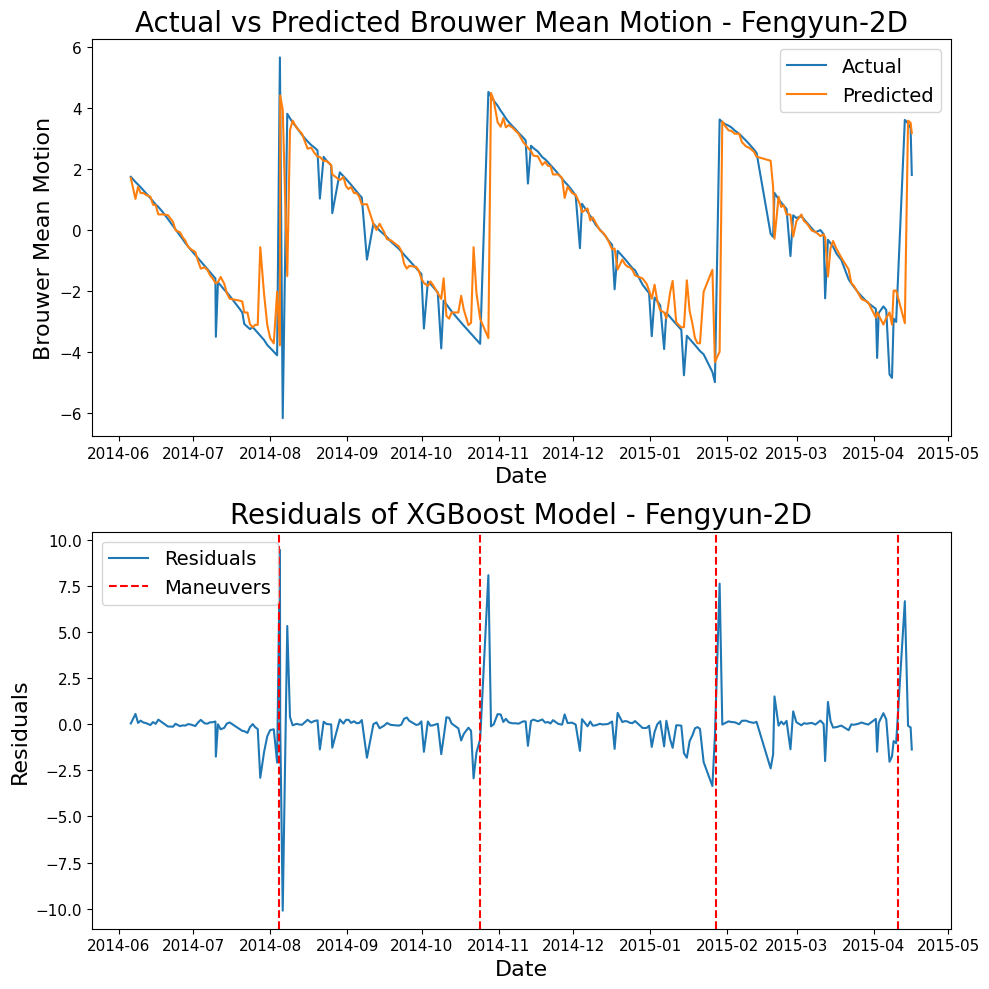

In [225]:
# Generating predictions
predictions = xgb_regressor.predict(df_bmm_x_test)

# Calculating residuals
residuals = df_bmm_y_test['Brouwer mean motion'].to_numpy() - predictions

# Creating a data frame for plotting
df_y_plotting = df_bmm_y_test.copy()
df_y_plotting["residuals"] = residuals
df_y_plotting["predictions"] = predictions

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = df_bmm_y_test.index, y = df_bmm_y_test["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["predictions"], label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - Fengyun-2D", fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=11)

# Plotting residuals
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["residuals"], label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of XGBoost Model - Fengyun-2D", fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=11)

start_date = pd.to_datetime("2014-08")
end_date = pd.to_datetime("2015-05")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [214]:
df_y_plotting

,Brouwer mean motion,residuals,predictions
2014-06-05 21:57:18.359711,1.751415,0.038622,1.712793
2014-06-07 18:49:38.232191,1.582145,0.555279,1.026866
2014-06-08 20:09:29.896703,1.494893,0.068614,1.426279
2014-06-09 20:30:38.066400,1.411569,0.192077,1.219492
2014-06-10 23:26:19.720031,1.310792,0.091300,1.219492
...,...,...,...
2015-04-10 01:46:29.584127,-3.007901,-1.031797,-1.976105
2015-04-13 13:46:11.083296,3.617698,6.663840,-3.046142
2015-04-14 20:58:23.309760,3.505147,-0.087531,3.592677
2015-04-15 21:43:48.910080,3.347217,-0.176952,3.524168


In [215]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = df_y_plotting["residuals"].sort_values().abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series =residuals_series.dropna()
residuals_series

2014-06-05 21:57:18.359711    0.038622
2014-06-07 18:49:38.232191    0.555279
2014-06-08 20:09:29.896703    0.068614
2014-06-09 20:30:38.066400    0.192077
2014-06-10 23:26:19.720031    0.091300
                                ...   
2015-04-10 01:46:29.584127    1.031797
2015-04-13 13:46:11.083296    6.663840
2015-04-14 20:58:23.309760    0.087531
2015-04-15 21:43:48.910080    0.176952
2015-04-16 09:12:35.675136    1.372779
Name: residuals, Length: 236, dtype: float64

In [216]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0    2015-04-10 15:30:00
1    2015-01-27 14:30:00
2    2014-10-24 15:30:00
3    2014-08-04 15:30:00
4    2014-05-09 15:30:00
5    2014-02-20 15:30:00
6    2013-11-22 15:30:00
7    2013-09-16 15:30:00
8    2013-06-25 15:30:00
9    2013-04-09 15:30:00
10   2013-02-05 15:30:00
11   2012-12-25 11:00:00
12   2012-11-01 09:30:00
13   2012-08-10 15:00:00
14   2012-05-16 10:00:00
15   2012-03-12 15:30:00
16   2011-12-29 16:30:00
17   2011-10-17 09:00:00
18   2011-08-04 15:30:00
19   2011-06-02 15:30:00
20   2011-03-28 16:00:00
21   2011-02-01 15:00:00
Name: Start_Date, dtype: datetime64[ns]

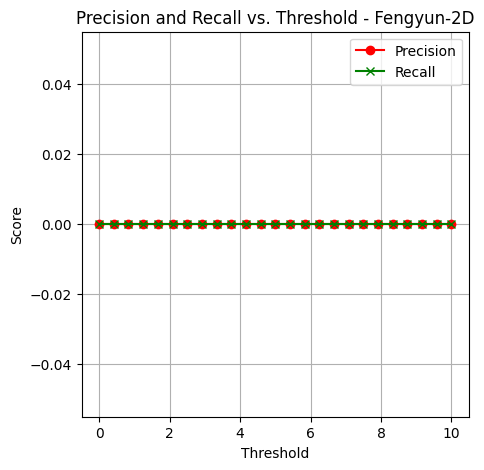

In [217]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - Fengyun-2D')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,10,25)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

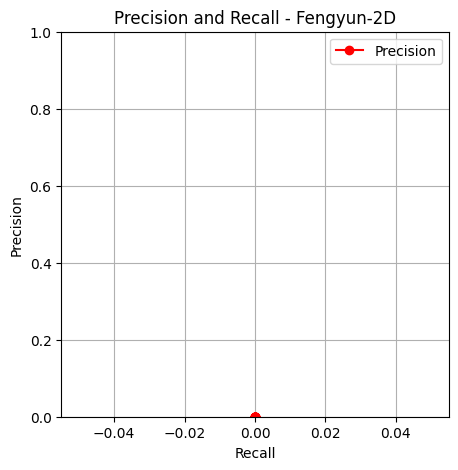

In [218]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - Fengyun-2D')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

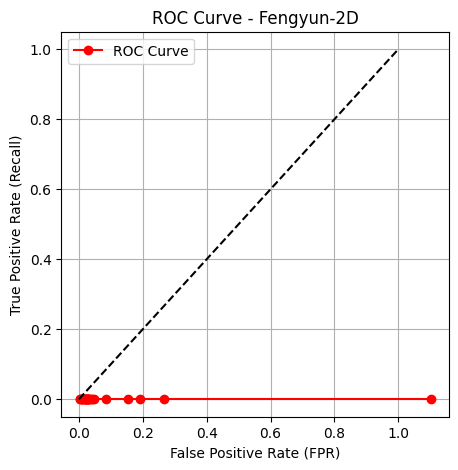

In [219]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - Fengyun-2D')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

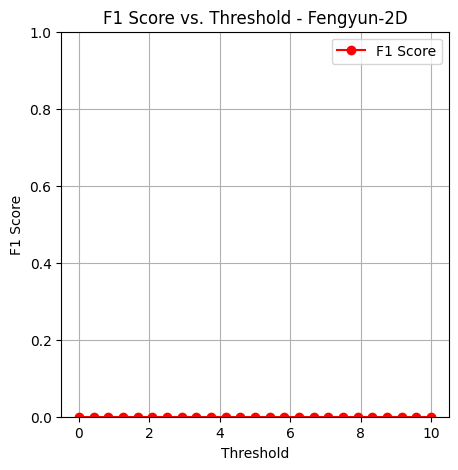

In [220]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - Fengyun-2D')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [221]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0
0.0


In [222]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

0.0
0.0
